In [165]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
def f(x):
  return 3*x**2 - 4*x + 5

In [115]:
#f(3)
print("hello")

hello


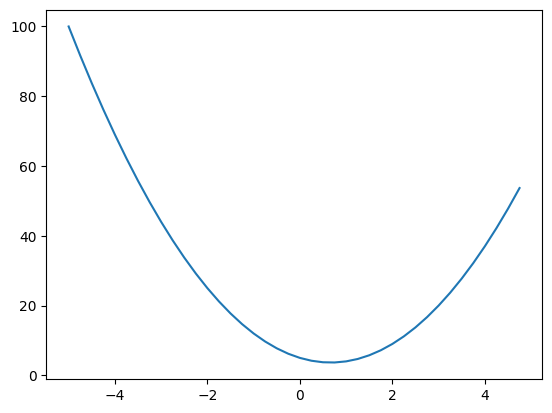

In [4]:
xs = np.arange(-5, 5, .25)
ys = f(xs)
plt.plot(xs, ys)

In [5]:
h = 0.0001

# inputs
a = 2
b = -3
c = 10

d1 = a*b + c
c += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1) / h)


d1 4
d2 4.0001
slope 0.9999999999976694


In [50]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        
        dot.node(name=uid, label="{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        
        if n._op:
            dot.node(name = uid + n._op, label = n._op)
            dot.edge(uid + n._op, uid)
            
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [153]:
# Value object

class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self._backprop = lambda: None
        self.label = label
        self.grad = 0

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        if not isinstance(other, Value):
            other = Value(other)
        
        out = Value(self.data + other.data, (self, other), '+')

        def _backprop():
            self.grad += out.grad
            other.grad += out.grad
        
        out._backprop = _backprop
        return out
    
    def __radd__(self, other):
        return self + other
    
    def __neg__(self):
        return -1 * self
    
    def __sub__(self, other):
        return self + (-other)


    def __mul__(self, other):
        if not isinstance(other, Value):
            other = Value(other)
        
        out = Value(self.data * other.data, (self, other), '*')

        def _backprop():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
            
        out._backprop = _backprop

        return out
    
    def __rmul__(self, other):
        return self * other
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only support int/float powers"
        out = Value(self.data ** other, (self,), f'**{other}')

        def _backprop():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backprop = _backprop

        return out
    
    def __truediv__(self, other):
        return self * other**-1
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backprop():
            self.grad += (1 - t**2) * out.grad
        out._backprop = _backprop

        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')

        def _backprop():
            self.grad += out.data * out.grad

        out._backprop = _backprop
        return out
  
    def backward(self):
        # build topological graph
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        topo

        self.grad = 1
        for node in reversed(topo):
            node._backprop()

In [154]:
a = Value(2)
b = Value(4)
a/b
a-b

Value(data=-2)

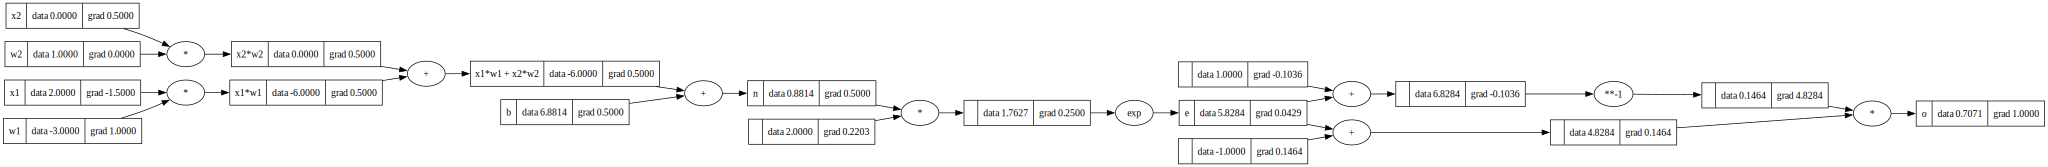

In [157]:
# inputs x1 x2
x1 = Value(2, label='x1')
x2 = Value(0, label='x2')
w1 = Value(-3, label='w1')
w2 = Value(1, label='w2')
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label ='x1*w1'
x2w2 = x2*w2; x2w2.label ='x2*w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
e = (2*n).exp(); e.label = 'e'
o = (e - 1) / (e + 1); o.label = 'o'
o.backward()
draw_dot(o)

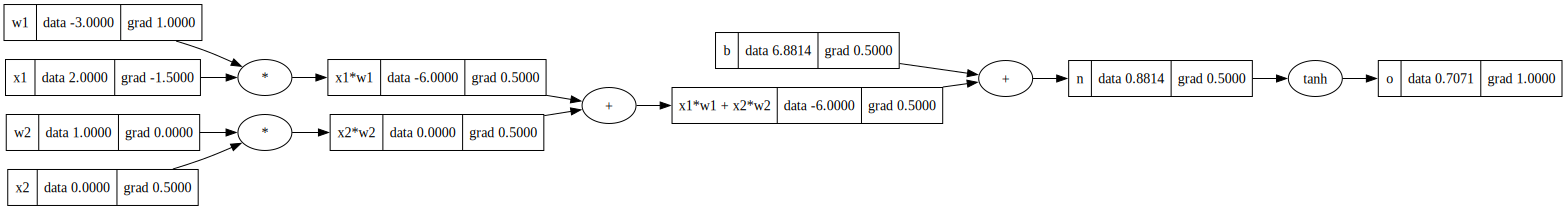

In [155]:
# inputs x1 x2
x1 = Value(2, label='x1')
x2 = Value(0, label='x2')
w1 = Value(-3, label='w1')
w2 = Value(1, label='w2')
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label ='x1*w1'
x2w2 = x2*w2; x2w2.label ='x2*w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()
draw_dot(o)

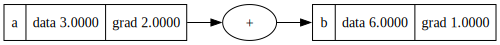

In [112]:
# bug
# FIX: must accumulate gradients using += rather than =
a = Value(3, label='a')
b = a+a; b.label='b'
b.backward()
draw_dot(b)

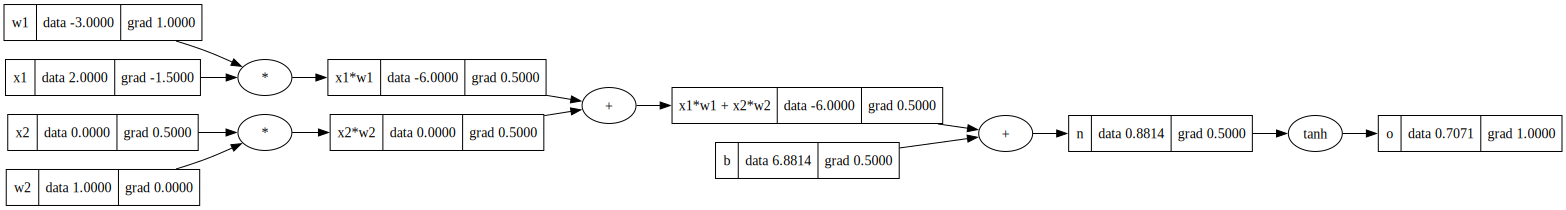

In [87]:
# Manual backprop
o.grad = 1
n.grad = 1 - o.data**2
b.grad = .5
x1w1x2w2.grad = .5

x1w1.grad = .5
x2w2.grad = .5

x1.grad = w1.data * .5
w1.grad = x1.data * .5

x2.grad = w2.data * .5
w2.grad = x2.data * .5
draw_dot(o)

In [159]:
# PyTorch comparison
import torch

x1 = torch.Tensor([2]).double() ; x1.requires_grad = True
x2 = torch.Tensor([0]).double() ; x2.requires_grad = True
w1 = torch.Tensor([-3]).double() ; w1.requires_grad = True
w2 = torch.Tensor([1]).double() ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double() ; b.requires_grad = True

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [173]:
o.data

tensor([0.7071], dtype=torch.float64)

In [227]:
class Neuron:
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))

  def __call__(self, x):
    act = sum(wi*xi for wi, xi in zip(self.w, x)) + self.b
    out = act.tanh()
    return out
  
  def parameters(self):
    return self.w + [self.b]
  
# x = [2,3]
# n = Neuron(2)
# n(x)

class Layer:
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs
  
  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]
  
class MLP:
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [238]:
x = [2,3,-1]
n = MLP(3, [4,4,1])
n(x)

Value(data=-0.42068899097298634)

In [229]:
len(n.parameters())

41

In [239]:
xs = [
  [2,3,-1],
  [3,-1,.5],
  [.5,1,1],
  [1,1,-1]
]

ys = [1,-1,-1,1]

In [251]:
for k in range(20):
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

  # HAVE TO ZERO GRAD BEFORE BACKWARD
  for p in n.parameters():
    p.grad = 0.0

  loss.backward()

  for p in n.parameters():
    p.data += -0.05 * p.grad

  print(k, loss.data)


0 0.005111185508638866
1 0.005076088860060129
2 0.005041457791943075
3 0.0050072832121655225
4 0.004973556262170558
5 0.004940268309548847
6 0.004907410940900837
7 0.004874975954966901
8 0.004842955356013504
9 0.004811341347464422
10 0.004780126325766602
11 0.0047493028744807235
12 0.0047188637585865705
13 0.004688801918994735
14 0.004659110467255523
15 0.0046297826804571635
16 0.004600811996305231
17 0.004572192008376126
18 0.004543916461537383
19 0.004515979247527752


In [252]:
ypred

[Value(data=0.9714109621257218),
 Value(data=-0.9803813440916717),
 Value(data=-0.9573116074933925),
 Value(data=0.9613806312000925)]

In [210]:
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=3.9122869580262276)

In [207]:
loss.backward()

In [200]:
n.layers[0].neurons[0].w[0].grad

-9.557662696404165

In [201]:
n.layers[0].neurons[0].w[0].data

0.1882681855618351

In [217]:
for p in n.parameters():
  p.data += -0.01 * p.grad

In [218]:
n.layers[0].neurons[0].w[0].data

9.30067378671074

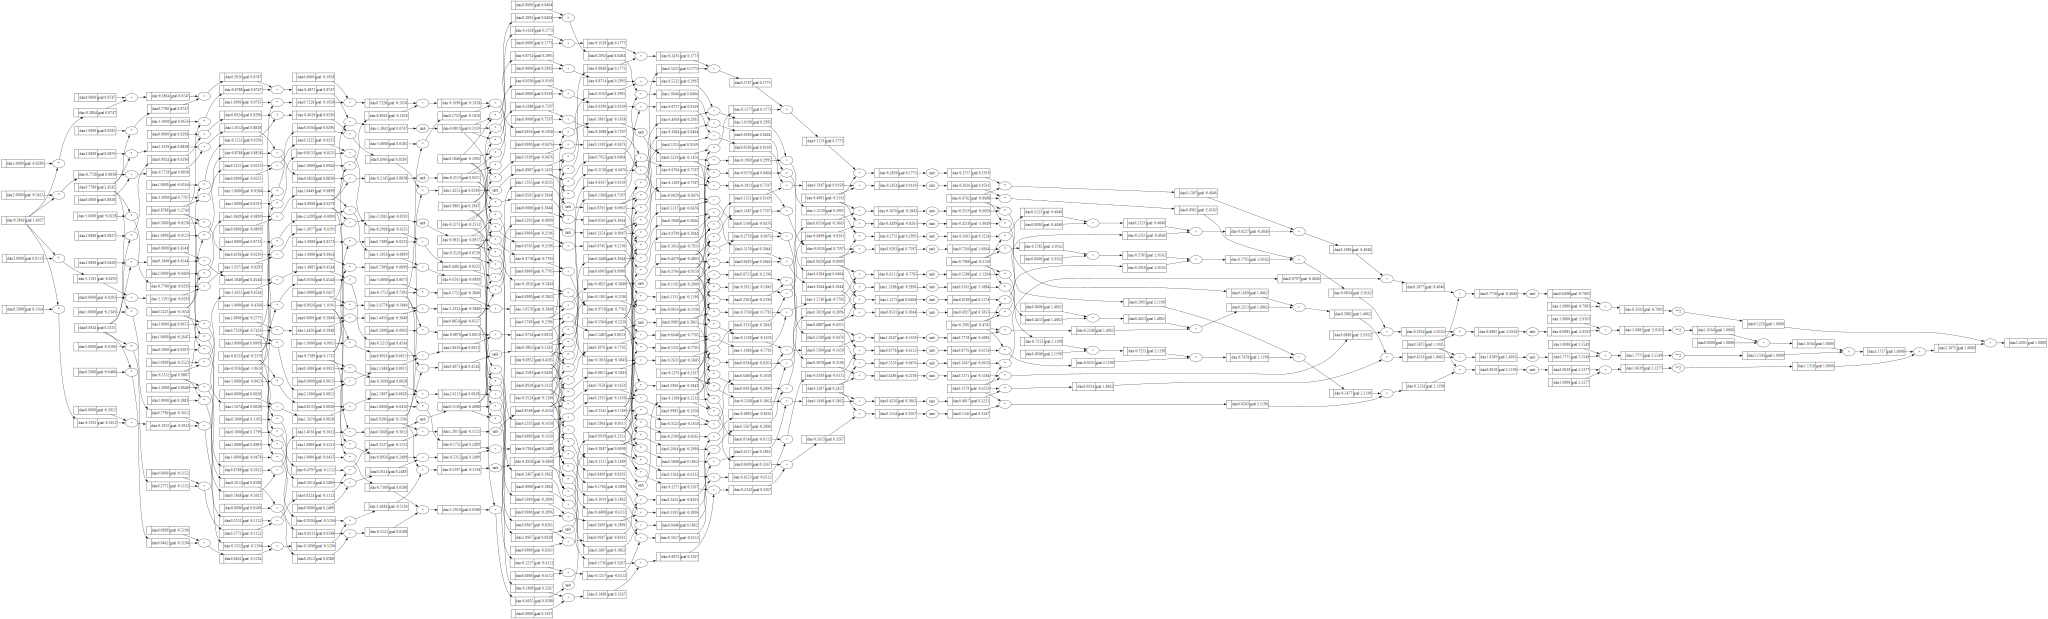

In [183]:
draw_dot(loss)

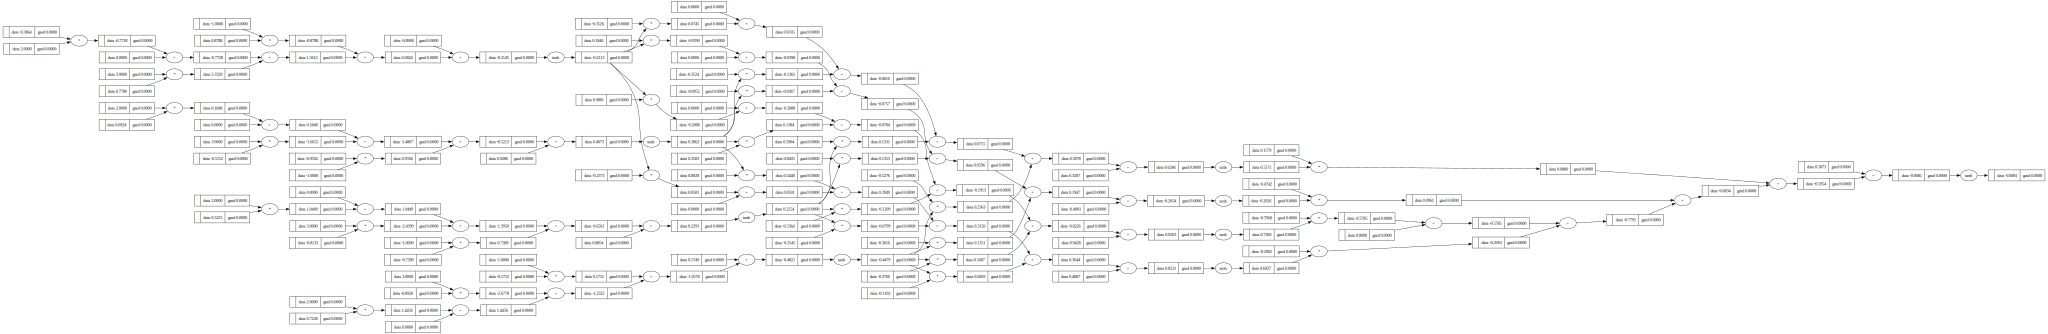

In [178]:
draw_dot(n(x))